# Cauchy distribution

In [1]:
import numpy as np
import cvxpy as cp
from scipy.integrate import quad
import matplotlib.pyplot as plt
import matplotlib
from DP.utils import fisher_information_privatized
from DP.pga_with_edge_traversal import PGAETMultipleRestarts
from DP.linear_solver import LinearSolver

matplotlib.style.use("bmh")

# Utility functions for the Cauchy distribution
def cauchy_cumulative(x, theta):
    return np.arctan(x - theta) / np.pi + 0.5

def cauchy_quantile(p, theta):
    return np.tan(np.pi * (p - 0.5)) + theta

def cauchy_pdf(x, theta):
    return 1 / (np.pi * (1 + (x - theta)**2))

# Initialize bins and probabilities
def initialize_bins_and_probabilities_cauchy(k, theta):
    bin_endpoints = [cauchy_quantile(i / k, theta) for i in range(k + 1)]
    p_theta = np.array([
        cauchy_cumulative(bin_endpoints[i + 1], theta) - cauchy_cumulative(bin_endpoints[i], theta)
        for i in range(k)
    ])
    p_theta_dot = np.array([
        cauchy_pdf(cauchy_quantile((i - 1) / k, theta), theta)
        - cauchy_pdf(cauchy_quantile(i / k, theta), theta)
        for i in range(1, k + 1)
    ])
    return p_theta, p_theta_dot

In [4]:
def observe_fisher_information_cauchy(theta, epsilon_low, epsilon_high, max_bins_pgaet, max_bins_linear, restarts=5):
    ks_pgaet = np.arange(2, max_bins_pgaet + 1)
    ks_linear = np.arange(2, max_bins_linear + 1)
    fisher_information_pgaet_low = np.zeros(len(ks_pgaet))
    fisher_information_pgaet_high = np.zeros(len(ks_pgaet))
    fisher_information_linear_low = np.zeros(len(ks_linear))
    fisher_information_linear_high = np.zeros(len(ks_linear))
    pgaet = PGAETMultipleRestarts(n_restarts=restarts)
    ls = LinearSolver()

    for i, k in enumerate(ks_pgaet):
        print(f"PGAET: theta={theta}, epsilon={epsilon_low}, k={k}")
        p_theta, p_theta_dot = initialize_bins_and_probabilities_cauchy(k, theta)
        results = pgaet(p_theta, p_theta_dot, epsilon_low, k)
        fisher_information_pgaet_low[i] = fisher_information_privatized(results["Q_matrix"], p_theta, p_theta_dot)

        print(f"PGAET: theta={theta}, epsilon={epsilon_high}, k={k}")
        p_theta, p_theta_dot = initialize_bins_and_probabilities_cauchy(k, theta)
        results = pgaet(p_theta, p_theta_dot, epsilon_high, k)
        fisher_information_pgaet_high[i] = fisher_information_privatized(results["Q_matrix"], p_theta, p_theta_dot)
    
    for i, k in enumerate(ks_linear):
        print(f"Linear: theta={theta}, epsilon={epsilon_low}, k={k}")
        p_theta, p_theta_dot = initialize_bins_and_probabilities_cauchy(k, theta)
        results = ls(p_theta, p_theta_dot, epsilon_low, k)
        fisher_information_linear_low[i] = fisher_information_privatized(results["Q_matrix"], p_theta, p_theta_dot)

        print(f"Linear: theta={theta}, epsilon={epsilon_high}, k={k}")
        p_theta, p_theta_dot = initialize_bins_and_probabilities_cauchy(k, theta)
        results = ls(p_theta, p_theta_dot, epsilon_high, k)
        fisher_information_linear_high[i] = fisher_information_privatized(results["Q_matrix"], p_theta, p_theta_dot)

    return ks_pgaet, fisher_information_pgaet_low, fisher_information_pgaet_high, ks_linear, fisher_information_linear_low, fisher_information_linear_high

def plot_fisher_information_cauchy(theta, epsilon_low, epsilon_high, max_bins_pgaet, max_bins_linear, restarts=5):
    ks_pgaet, fisher_information_pgaet_low, fisher_information_pgaet_high, ks_linear, fisher_information_linear_low, fisher_information_linear_high = observe_fisher_information_cauchy(
        theta, epsilon_low, epsilon_high, max_bins_pgaet, max_bins_linear, restarts=restarts
    )

    fig, ax = plt.subplots(figsize=(8, 6), nrows=2)

    ax[0].plot(ks_pgaet, fisher_information_pgaet_low, label=rf"PGAET ($\epsilon={epsilon_low}$)", marker="o")
    ax[0].plot(ks_linear, fisher_information_linear_low, label=rf"Linear ($\epsilon={epsilon_low}$)", marker="o")
    ax[0].set_ylabel("Fisher information")
    ax[0].set_title(f"Cauchy distribution, theta={theta}, epsilon={epsilon_low}")
    ax[0].legend()

    ax[1].plot(ks_pgaet, fisher_information_pgaet_high, label=rf"PGAET ($\epsilon={epsilon_high}$)", marker="o")
    ax[1].plot(ks_linear, fisher_information_linear_high, label=rf"Linear ($\epsilon={epsilon_high}$)", marker="o")
    ax[1].set_ylabel("Fisher information")
    ax[1].set_xlabel("Number of bins")
    ax[1].set_title(f"Cauchy distribution, theta={theta}, epsilon={epsilon_high}")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

### Cauchy

PGAET: theta=0, epsilon=1, k=2
PGAET: theta=0, epsilon=5, k=2
PGAET: theta=0, epsilon=1, k=3
PGAET: theta=0, epsilon=5, k=3
PGAET: theta=0, epsilon=1, k=4
PGAET: theta=0, epsilon=5, k=4
PGAET: theta=0, epsilon=1, k=5
PGAET: theta=0, epsilon=5, k=5
PGAET: theta=0, epsilon=1, k=6
PGAET: theta=0, epsilon=5, k=6
PGAET: theta=0, epsilon=1, k=7
PGAET: theta=0, epsilon=5, k=7
PGAET: theta=0, epsilon=1, k=8
PGAET: theta=0, epsilon=5, k=8
PGAET: theta=0, epsilon=1, k=9
PGAET: theta=0, epsilon=5, k=9
PGAET: theta=0, epsilon=1, k=10
PGAET: theta=0, epsilon=5, k=10
PGAET: theta=0, epsilon=1, k=11
PGAET: theta=0, epsilon=5, k=11
PGAET: theta=0, epsilon=1, k=12
PGAET: theta=0, epsilon=5, k=12
PGAET: theta=0, epsilon=1, k=13
PGAET: theta=0, epsilon=5, k=13
PGAET: theta=0, epsilon=1, k=14
PGAET: theta=0, epsilon=5, k=14
PGAET: theta=0, epsilon=1, k=15
PGAET: theta=0, epsilon=5, k=15
PGAET: theta=0, epsilon=1, k=16
PGAET: theta=0, epsilon=5, k=16
PGAET: theta=0, epsilon=1, k=17
PGAET: theta=0, epsilon=

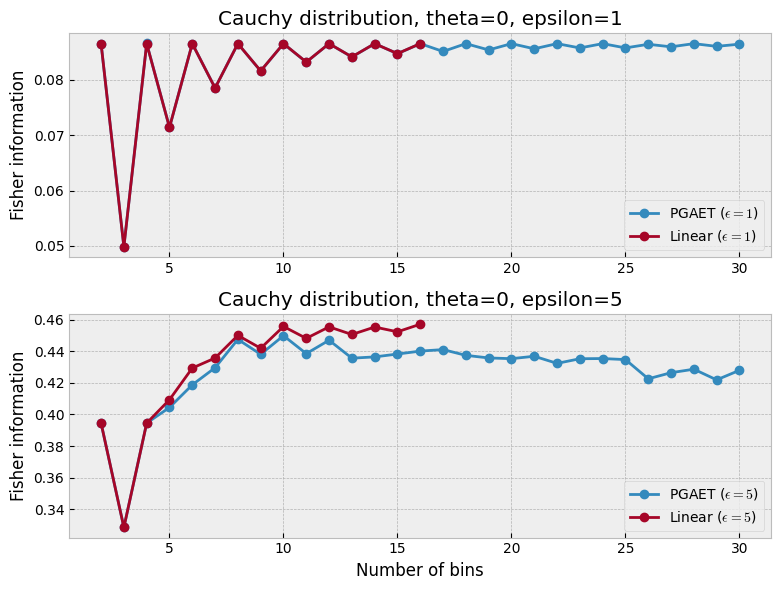

In [5]:
plot_fisher_information_cauchy(0, 1, 5, 30, 16, restarts=5)

PGAET: theta=0, epsilon=1, k=2
PGAET: theta=0, epsilon=5, k=2
PGAET: theta=0, epsilon=1, k=3
PGAET: theta=0, epsilon=5, k=3
PGAET: theta=0, epsilon=1, k=4
PGAET: theta=0, epsilon=5, k=4
PGAET: theta=0, epsilon=1, k=5
PGAET: theta=0, epsilon=5, k=5
PGAET: theta=0, epsilon=1, k=6
PGAET: theta=0, epsilon=5, k=6


/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


PGAET: theta=0, epsilon=1, k=7
PGAET: theta=0, epsilon=5, k=7
PGAET: theta=0, epsilon=1, k=8
PGAET: theta=0, epsilon=5, k=8
PGAET: theta=0, epsilon=1, k=9
PGAET: theta=0, epsilon=5, k=9
PGAET: theta=0, epsilon=1, k=10
PGAET: theta=0, epsilon=5, k=10
PGAET: theta=0, epsilon=1, k=11
PGAET: theta=0, epsilon=5, k=11
PGAET: theta=0, epsilon=1, k=12
PGAET: theta=0, epsilon=5, k=12
PGAET: theta=0, epsilon=1, k=13
PGAET: theta=0, epsilon=5, k=13
PGAET: theta=0, epsilon=1, k=14
PGAET: theta=0, epsilon=5, k=14
PGAET: theta=0, epsilon=1, k=15
PGAET: theta=0, epsilon=5, k=15
Linear: theta=0, epsilon=1, k=2
Linear: theta=0, epsilon=5, k=2
Linear: theta=0, epsilon=1, k=3
Linear: theta=0, epsilon=5, k=3
Linear: theta=0, epsilon=1, k=4
Linear: theta=0, epsilon=5, k=4
Linear: theta=0, epsilon=1, k=5
Linear: theta=0, epsilon=5, k=5
Linear: theta=0, epsilon=1, k=6
Linear: theta=0, epsilon=5, k=6
Linear: theta=0, epsilon=1, k=7
Linear: theta=0, epsilon=5, k=7
Linear: theta=0, epsilon=1, k=8
Linear: theta=

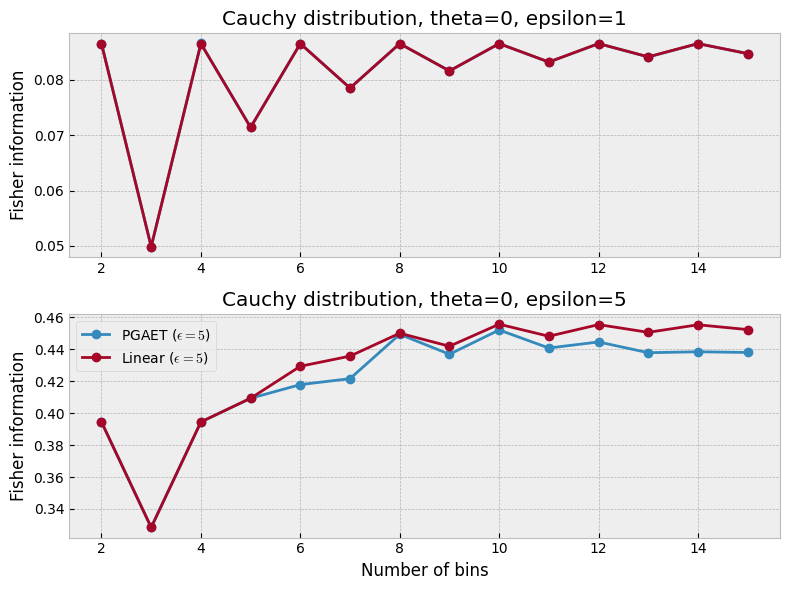

In [3]:
plot_fisher_information_cauchy(0, 1, 5, 15, 15, restarts=5)

## Gaussian distribution

In [5]:
# Utility functions for the Gaussian distribution
def gaussian_cumulative(x, theta, sigma=1):
    from scipy.stats import norm
    return norm.cdf(x, loc=theta, scale=sigma)

def gaussian_quantile(p, theta, sigma=1):
    from scipy.stats import norm
    return norm.ppf(p, loc=theta, scale=sigma)

def gaussian_pdf(x, theta, sigma=1):
    from scipy.stats import norm
    return norm.pdf(x, loc=theta, scale=sigma)

def fisher_information(Q, p_theta, p_theta_dot):
    numerator = np.power(Q @ p_theta_dot, 2)
    denominator = Q @ p_theta
    # Safeguard against division by very small values
    denominator[denominator < 1e-12] = 1e-12
    return np.sum(numerator / denominator)

# Initialize bins and probabilities for Gaussian model
def initialize_gaussian_bins_and_probabilities(k, theta, sigma=1):
    bin_endpoints = [gaussian_quantile(i / k, theta, sigma) for i in range(k + 1)]
    p_theta = np.array([
        gaussian_cumulative(bin_endpoints[i + 1], theta, sigma) - gaussian_cumulative(bin_endpoints[i], theta, sigma)
        for i in range(k)
    ])
    p_theta_dot = np.array([
        gaussian_pdf(gaussian_quantile((i - 1) / k, theta, sigma), theta, sigma)
        - gaussian_pdf(gaussian_quantile(i / k, theta, sigma), theta, sigma)
        for i in range(1, k + 1)
    ])
    return p_theta, p_theta_dot

In [2]:
def observe_fisher_information_gauss(theta, epsilon, max_bins_pgaet, max_bins_linear, restarts=5):
    ks_pgaet = np.arange(2, max_bins_pgaet + 1)
    ks_linear = np.arange(2, max_bins_linear + 1)
    fisher_information_pgaet = np.zeros(len(ks_pgaet))
    fisher_information_linear = np.zeros(len(ks_linear))
    pgaet = PGAETMultipleRestarts(n_restarts=restarts)
    ls = LinearSolver()

    for i, k in enumerate(ks_pgaet):
        print(f"PGAET: theta={theta}, epsilon={epsilon}, k={k}")
        p_theta, p_theta_dot = initialize_gaussian_bins_and_probabilities(k, theta)
        results = pgaet(p_theta, p_theta_dot, epsilon, k)
        fisher_information_pgaet[i] = fisher_information_privatized(results["Q_matrix"], p_theta, p_theta_dot)
    
    for i, k in enumerate(ks_linear):
        print(f"Linear: theta={theta}, epsilon={epsilon}, k={k}")
        p_theta, p_theta_dot = initialize_gaussian_bins_and_probabilities(k, theta)
        results = ls(p_theta, p_theta_dot, epsilon, k)
        fisher_information_linear[i] = fisher_information_privatized(results["Q_matrix"], p_theta, p_theta_dot)

    return ks_pgaet, fisher_information_pgaet, ks_linear, fisher_information_linear

def plot_fisher_information_gauss(theta, epsilon, max_bins_pgaet, max_bins_linear, restarts=5):
    ks_pgaet, fisher_information_pgaet, ks_linear, fisher_information_linear = observe_fisher_information_gauss(
        theta, epsilon, max_bins_pgaet, max_bins_linear, restarts=restarts
    )

    plt.plot(ks_pgaet, fisher_information_pgaet, label="PGAET", marker="o")
    plt.plot(ks_linear, fisher_information_linear, label="Linear", marker="o")
    plt.xlabel("Number of bins")
    plt.ylabel("Fisher information")
    plt.title(f"Normal distribution, theta={theta}, epsilon={epsilon}")
    plt.legend()
    plt.show()

#### Low epsilon

PGAET: theta=0, epsilon=0.5, k=2
PGAET: theta=0, epsilon=0.5, k=3
PGAET: theta=0, epsilon=0.5, k=4
PGAET: theta=0, epsilon=0.5, k=5
PGAET: theta=0, epsilon=0.5, k=6
PGAET: theta=0, epsilon=0.5, k=7
PGAET: theta=0, epsilon=0.5, k=8
PGAET: theta=0, epsilon=0.5, k=9
PGAET: theta=0, epsilon=0.5, k=10
PGAET: theta=0, epsilon=0.5, k=11
PGAET: theta=0, epsilon=0.5, k=12
PGAET: theta=0, epsilon=0.5, k=13
PGAET: theta=0, epsilon=0.5, k=14
PGAET: theta=0, epsilon=0.5, k=15
PGAET: theta=0, epsilon=0.5, k=16
PGAET: theta=0, epsilon=0.5, k=17
PGAET: theta=0, epsilon=0.5, k=18
PGAET: theta=0, epsilon=0.5, k=19
PGAET: theta=0, epsilon=0.5, k=20
PGAET: theta=0, epsilon=0.5, k=21
PGAET: theta=0, epsilon=0.5, k=22
PGAET: theta=0, epsilon=0.5, k=23
PGAET: theta=0, epsilon=0.5, k=24
PGAET: theta=0, epsilon=0.5, k=25
PGAET: theta=0, epsilon=0.5, k=26
PGAET: theta=0, epsilon=0.5, k=27
PGAET: theta=0, epsilon=0.5, k=28
PGAET: theta=0, epsilon=0.5, k=29
PGAET: theta=0, epsilon=0.5, k=30
Linear: theta=0, epsil

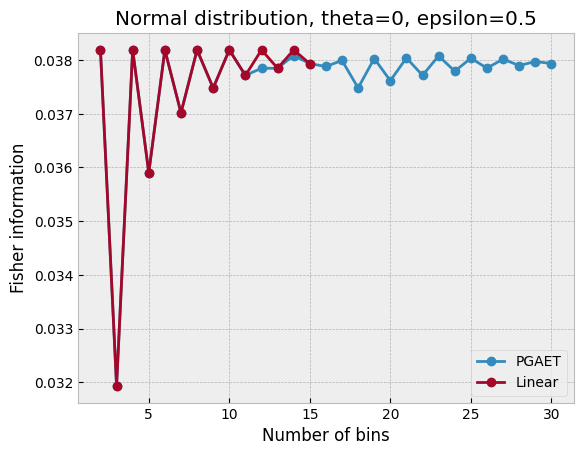

In [9]:
plot_fisher_information_gauss(0, 0.5, 30, 15, restarts=5)

#### High epsilon

PGAET: theta=0, epsilon=10, k=2
PGAET: theta=0, epsilon=10, k=3
PGAET: theta=0, epsilon=10, k=4
PGAET: theta=0, epsilon=10, k=5
PGAET: theta=0, epsilon=10, k=6
PGAET: theta=0, epsilon=10, k=7
PGAET: theta=0, epsilon=10, k=8
PGAET: theta=0, epsilon=10, k=9
PGAET: theta=0, epsilon=10, k=10
PGAET: theta=0, epsilon=10, k=11
PGAET: theta=0, epsilon=10, k=12
PGAET: theta=0, epsilon=10, k=13
PGAET: theta=0, epsilon=10, k=14
PGAET: theta=0, epsilon=10, k=15
PGAET: theta=0, epsilon=10, k=16
PGAET: theta=0, epsilon=10, k=17
PGAET: theta=0, epsilon=10, k=18
PGAET: theta=0, epsilon=10, k=19
PGAET: theta=0, epsilon=10, k=20
Linear: theta=0, epsilon=10, k=2
Linear: theta=0, epsilon=10, k=3
Linear: theta=0, epsilon=10, k=4
Linear: theta=0, epsilon=10, k=5
Linear: theta=0, epsilon=10, k=6
Linear: theta=0, epsilon=10, k=7
Linear: theta=0, epsilon=10, k=8
Linear: theta=0, epsilon=10, k=9
Linear: theta=0, epsilon=10, k=10
Linear: theta=0, epsilon=10, k=11
Linear: theta=0, epsilon=10, k=12
Linear: theta=0

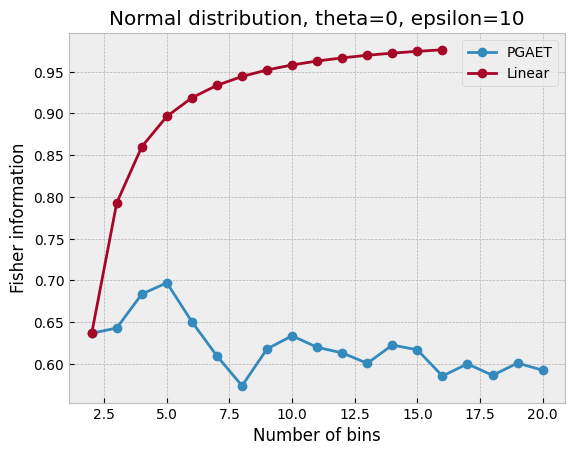

In [8]:
plot_fisher_information_gauss(0, 10, 20, 16, restarts=5)